In [1]:
##############      Configuración      ##############
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
from dotenv import dotenv_values

pd.set_option("display.max_columns", None)
env = dotenv_values("/mnt/d/Maestría/Tesis/Repo/scripts/globals.env")

path_proyecto = env["PATH_PROYECTO"]
path_datain = env["PATH_DATAIN"]
path_dataout = env["PATH_DATAOUT"]
path_out_imgs = r"/mnt/e/Tesis Maestría/imagenes"
path_scripts = env["PATH_SCRIPTS"]
path_satelites = env["PATH_SATELITES"]
path_logs = env["PATH_LOGS"]
path_outputs = env["PATH_OUTPUTS"]

In [2]:
import earthpy.plot as ep
import build_dataset as bd
import utils
import geopandas as gpd
import shapely
import skimage
import folium
import pandas as pd
import seaborn as sns

raster_size = 58.435144 - 58.435139 # In epsg 4326 degrees

Links without images: 3448 out of 11666


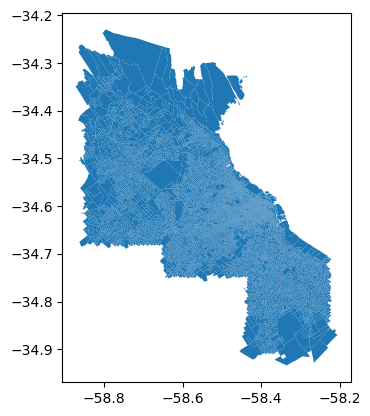

In [3]:
datasets, extents = bd.load_satellite_datasets()
icpag = bd.load_icpag_dataset()
icpag = bd.assign_links_to_datasets(icpag, extents)

# Imagenes de Ejemplo

/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


(-0.5, 127.5, 127.5, -0.5)

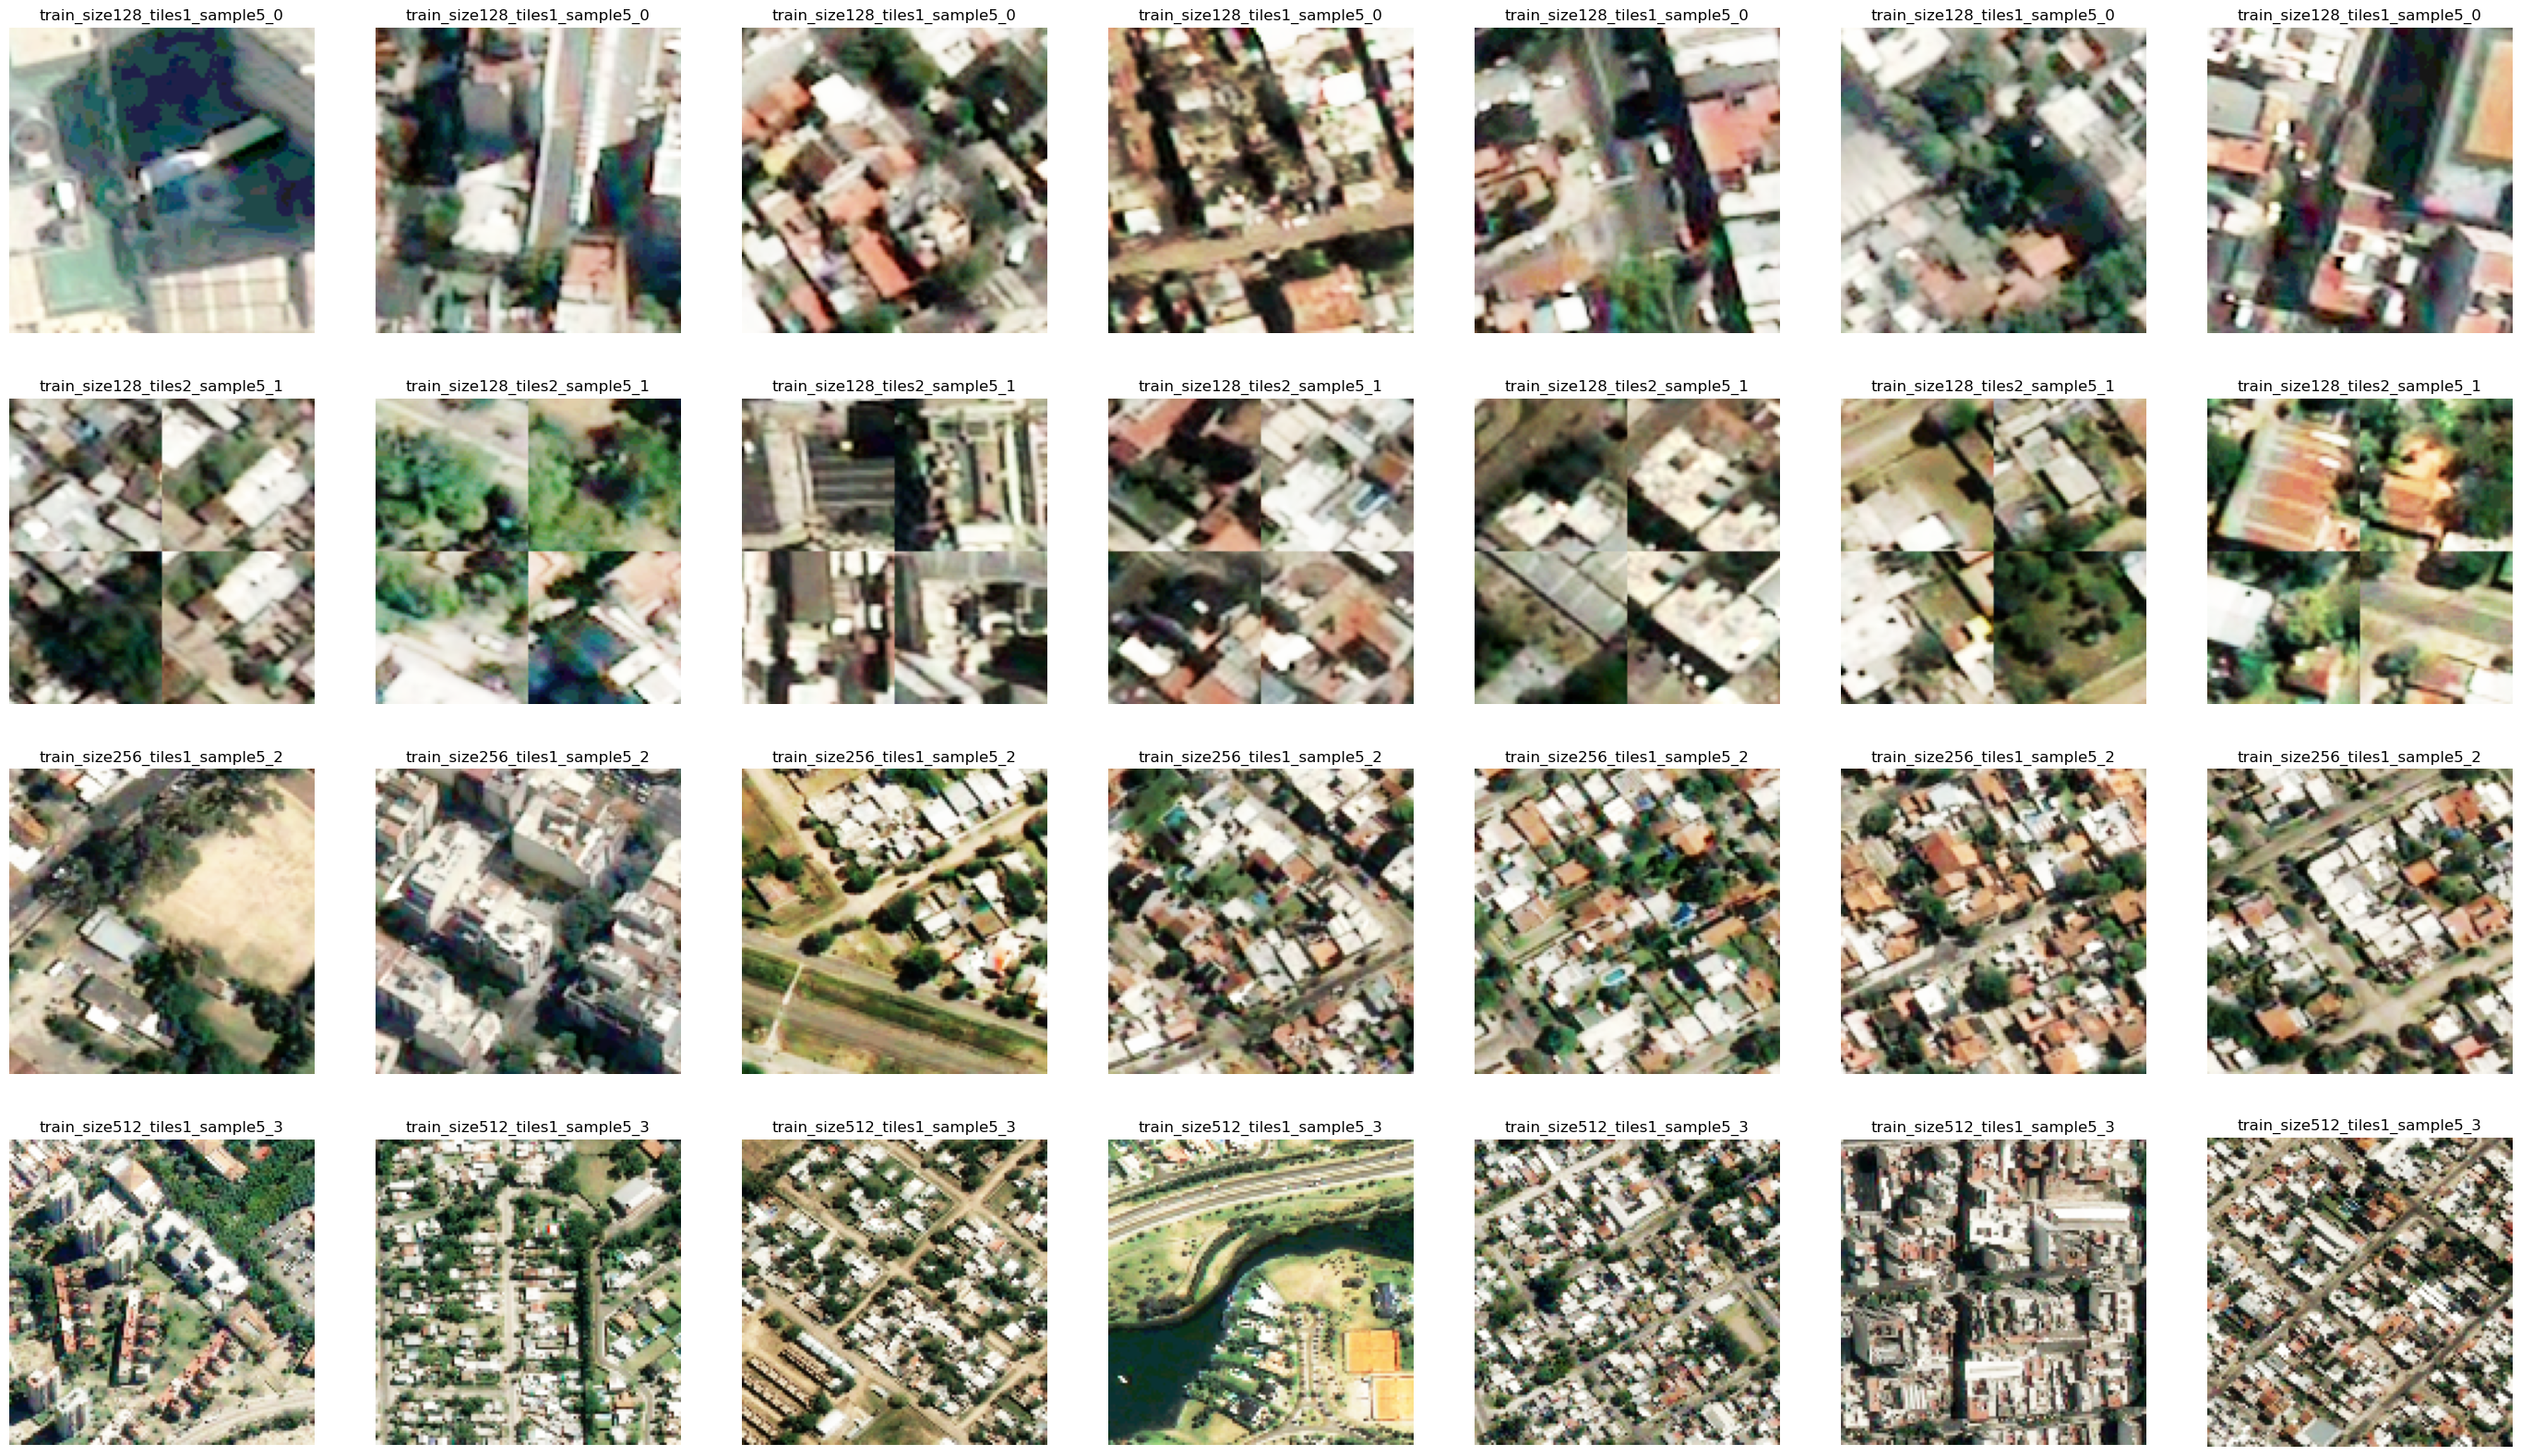

In [4]:
import random
import skimage
import cv2
import os
img_folders = os.listdir(path_out_imgs)
img_folders = [folder for folder in img_folders if "train" in folder]

fig, axs = plt.subplots(4,7, figsize=(5*7, 5*4))
for row, folder in enumerate(img_folders):

    imgs = os.listdir(f"{path_out_imgs}/{folder}")
    show_imgs = random.sample(imgs, 7)

    for col, im_path in enumerate(show_imgs):

        im = np.load(f"{path_out_imgs}/{folder}/{im_path}")
        im = np.moveaxis(im, 0, 2)
        im = im[:,:,:3]
        # Equalize hist
        im = skimage.exposure.equalize_hist(im)
        im = cv2.resize(im, (128, 128))

        axs[row][col].imshow(im[:,:,:3])
        axs[row][col].set_axis_off()
        axs[row][col].set_title(f"{folder}_{row}")
        
# Remove axis lables
plt.axis("tight")

# True Mean Squared error

In [5]:
from tqdm import tqdm
import pandas as pd

path_repo = r"/mnt/d/Maestría/Tesis/Repo"
# path_repo = r"D:/Maestría/Tesis/Repo"
path_outputs = f"{path_repo}/outputs"
path_dataout = f"{path_repo}/data/data_out"

def get_model_results(modelname):
    
    folder = f"{path_repo}/data/data_out/models_by_epoch/{modelname}"

    # Get train dataset
    train_data = pd.read_csv(rf"{path_dataout}/training_by_epoch.csv")
    mse_train_df = train_data[[modelname]]
    # TODO: Calcular el R2
    mse_train_df = mse_train_df.reset_index().rename(columns={'index':'epoch', modelname:'mse_train'})

    # Get validation (test by each image) dataset
    test2_data = pd.read_csv(rf"{path_dataout}/validation_by_epoch.csv")
    mse_test2_df = test2_data[[modelname]]
    # TODO: Calcular el R2
    mse_test2_df = mse_test2_df.reset_index().rename(columns={'index':'epoch', modelname:'mse_test_imgs'})

    # Get test dataset
    mse_test_df = pd.DataFrame()
    for epoch in tqdm(range(0, 200)):

        df = pd.read_csv(f"{folder}/{modelname}_{epoch}.csv")
        mse = df.groupby("link").sq_error.mean().mean()

        mse_test_df.at[epoch, 'mse_test_rc'] = mse
        mse_test_df.at[epoch, 'epoch'] = epoch    
    
    # Merge both df
    mse_df = mse_train_df.merge(mse_test_df, on='epoch')
    mse_df = mse_df.merge(mse_test2_df, on='epoch')

    return mse_df

In [6]:
def plot_mse_over_epochs(mse_df, modelname, metric="mse", save=False):
    import plotly.express as px
    from plotly import graph_objects as go

    plot_df = mse_df.melt(id_vars='epoch', value_vars=['mse_test_imgs', 'mse_test_rc','mse_train'])

    # Plot
    fig = px.line(plot_df, x="epoch", y="value", color="variable", title='True Mean Squared Error over epochs')
    fig.update_yaxes(range=[0, 1])

    fig.update_layout(
        autosize=False,
        width=1280,
        height=720,)

    if save:
        fig.write_image(f"{path_outputs}/mse_best_prediction_{modelname}.png")

    return fig
    
def plot_predictions_vs_real(mse_df, modelname, quantiles=False, last_training=False, save=False):
    import plotly.express as px
    from plotly import graph_objects as go

    folder = f"{path_repo}/data/data_out/models_by_epoch/{modelname}"
    
    # Select best epoch... ¿Is this correct?       
    best_case_epoch = mse_df.loc[mse_df["mse"]==mse_df["mse"].min()].index.values[0]

    if last_training:
        best_case_epoch = 199
        
    # Open dataset
    best_case = pd.read_csv(
        rf"{folder}/{modelname}_{best_case_epoch}.csv"
        )
    best_case = best_case.groupby("link")[['real_value', 'mean_prediction']].mean().reset_index()
    if quantiles:
        best_case['real_value'] = pd.qcut(best_case['real_value'], 100, labels=False)
        best_case['mean_prediction'] = pd.qcut(best_case['mean_prediction'], 100, labels=False)
        axis_range = [0, 100]
        title = f"{modelname} - cuantiles"
    else:
        axis_range = [-2, 2]
        title = f"{modelname} - niveles"
        
    import seaborn as sns
    fig = px.scatter(best_case, x="real_value", y="mean_prediction", hover_data=["link"],
                     title=title)
    fig.update_yaxes(range=axis_range)
    fig.update_xaxes(range=axis_range)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,)

    # Add 45° line
    line_fig = go.Figure(data=go.Scatter(x=best_case['real_value'], y=best_case['real_value'], mode='lines', name='45°'))
    fig.add_trace(line_fig.data[0])

    if save:
        if quantiles:
            fig.write_image(f"{path_outputs}/prediction_vs_real_best_prediction_{modelname}_q.png")
        else:
            fig.write_image(f"{path_outputs}/prediction_vs_real_best_prediction_{modelname}.png")
    return fig

In [7]:
def plot_all_over_epochs(modelnames, metric="mse", save=True):
    import plotly.express as px
    from plotly import graph_objects as go

    plot_data = []
    for modelname in modelnames:
        # Get data
        mse_df = get_model_results(modelname)

        # Prepare dataset for plot
        var_x = icpag.groupby("link")['var'].first().var()
        mse_df['r2'] = 1 - mse_df.mse / var_x
        mse_df['smoothed_mse'] = mse_df.rolling(20).mse.mean()
        mse_df['smoothed_r2'] = mse_df.rolling(20).r2.mean()

        melt_df = mse_df.melt(id_vars='epoch')
        plot_df = melt_df[melt_df.variable.isin([metric, f'smoothed_{metric}'])] 
        plot_df['name'] = f"{modelname}" + plot_df["variable"]
        plot_data += [plot_df.copy()]
        
    plot_data = pd.concat(plot_data)
    # Plot
    fig = px.line(plot_data, x="epoch", y="value", color="name")

    if metric=="mse":
        optimal_value_y = mse_df["mse"].min()
        name = "min_mse"
    elif metric=="r2":
        optimal_value_y = mse_df["r2"].max()
        name = "max_r2"
    else:
        raise ValueError("metric has to be either 'mse' or 'r2'")
    
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)

    
    fig.update_yaxes(range=[0.1, 1.2])
        
    if save:
        main_fig.write_image(f"{path_outputs}/{metric}_best_prediction_{modelname}.png")

    # fig.write_image(f"{path_outputs}/mse_best_prediction_mobnet_v3_size{size}_tiles{tiles}_sample{sample}.png")
    return fig


In [8]:
models =[
    "mobnet_v3_size128_tiles1_sample1",
    "mobnet_v3_size256_tiles1_sample1",
    "mobnet_v3_size512_tiles1_sample1",
    "mobnet_v3_size128_tiles2_sample20",
]
# plot_all_over_epochs(models, metric="mse", save=False)

In [9]:
for model in models: 
    mse_df = get_model_results(model)
    plot_mse_over_epochs(mse_df, model, metric="mse", save=True)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:24<00:00,  8.01it/s]
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/plotly/express/imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
100%|██████████| 200/200 [00:10<00:00, 19.78it/s]
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

100%|██████████|

In [33]:
plot_mse_over_epochs(mse_df, model, metric="mse", save=False)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [32]:
!py -m pip install -U kaleido


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
mse_df

epoch  mse_train   mse_test_rc  mse_test_imgs
0        0        NaN      0.831253            NaN
1        1        NaN      0.854382            NaN
2        2        NaN      0.888008            NaN
3        3        NaN    122.473856            NaN
4        4        NaN  28860.263906            NaN
..     ...        ...           ...            ...
195    195   0.072022      0.369752       0.491770
196    196   0.071292      0.365241       0.472416
197    197   0.071078      0.403135       0.498945
198    198   0.067654      0.452938       0.534262
199    199   0.069962      0.380889       0.514170

[200 rows x 4 columns]

In [20]:
models =[
    # "mobnet_v3_size128_tiles1_sample1",
    # "mobnet_v3_size256_tiles1_sample1",
    # "mobnet_v3_size512_tiles1_sample1",
    "mobnet_v3_size128_tiles2_sample20",
]

for modelname in models:
    mse_df = get_model_results(modelname)
    plot_mse_over_epochs(mse_df, modelname, metric="mse", save=True)
    plot_mse_over_epochs(mse_df, modelname, metric="r2", save=True)
    plot_predictions_vs_real(mse_df, modelname=modelname, save=True)
    plot_predictions_vs_real(mse_df, modelname=modelname, quantiles=True, save=True)


100%|██████████| 200/200 [00:15<00:00, 12.98it/s]
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/home/

In [9]:
modelname = rf"mobnet_v3_size128_tiles1_sample1"
mse_df = get_model_results(modelname)

100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


In [12]:
plot_predictions_vs_real(mse_df, modelname=modelname)

/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [13]:
plot_predictions_vs_real(mse_df, modelname=modelname, quantiles=True)

/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Gridded predictions

Links without images: 3448 out of 11666


2023-09-17 13:21:12.616275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-17 13:21:12.616952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-17 13:21:12.617451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-17 13:21:13.501770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-17 13:21:13.502324: I tensorflow/compile

1/1 [==============================] - 0s 60ms/step
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
1/1 [==============================] - 0s 72ms/step
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
1/1 [==============================] - 0s 59ms/step
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
1/1 [==============================] - 0s 67ms/step
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
Some tiles were not found. Image not generated...
1/1 [==============================] - 0s 60ms/step
Some tiles were not found. Image not gen

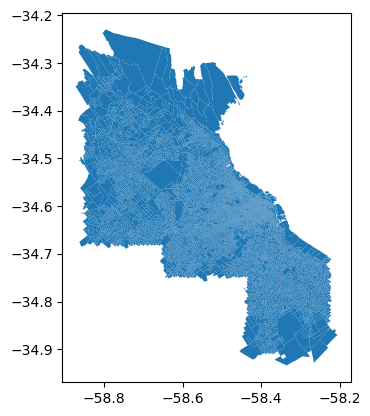

In [ ]:
import os
import importlib
import build_dataset
import run_model
import tensorflow as tf
importlib.reload(build_dataset)
importlib.reload(run_model)

# Load data
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents)

# Model
modelpath = rf"{folder}/mobnet_v3_size{size}_tiles{tiles}_sample{sample}_{best_case_epoch}"
model = tf.keras.models.load_model(
           modelpath, compile=True
        )

# Run predictions
grid_preds_folder = f"{path_repo}/data/data_out/gridded_predictions/mobnet_v3_size{size}_tiles{tiles}_sample{sample}"
os.makedirs(grid_preds_folder, exist_ok=True)

for name, ds in datasets.items():
    df_preds = build_dataset.get_gridded_images_for_dataset(
        model=model, ds=ds, icpag=icpag, tiles=1, size=size, resizing_size=128, bias=2, sample=1, to8bit=True
    )
    df_preds.to_parquet(f"{grid_preds_folder}/{name}.parquet")

In [ ]:
m = df_preds.explore(column="predictions", cmap="Spectral",
                tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
                vmax=df_preds.predictions.quantile(.95), vmin=df_preds.predictions.quantile(.05)
)
folium.LayerControl().add_to(m)
m

In [ ]:
import build_dataset

build_dataset.get_random_images_for_link(
    ds, icpag, link, 2, 512, 128, 2, 5, to8bit=True
)